## Import libraries

In [2]:
# Common
import numpy as np
import os
import sys

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import cv2
from six.moves import urllib

# sklearn 
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from category_encoders import TargetEncoder

print(tf.__version__)

2.12.0


## Load data

In [3]:
# load the data
train_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv', index_col='Id')
test_data = pd.read_csv('/kaggle/input/home-data-for-ml-course/test.csv', index_col='Id')

print('data loaded')

data loaded


In [4]:
# split the train data set
train_dataset, val_dataset = train_test_split(train_data, test_size=0.5, random_state=42)
print('train data splitted')

train data splitted


In [5]:
# extract labels from train data (target)
train_labels = train_dataset.pop('SalePrice')
val_labels = val_dataset.pop('SalePrice')

print('val and train labels extracted')

val and train labels extracted


In [6]:
# check the length of the data sets
print('len train_dataset: ', len(train_dataset))
print('len val_dataset: ', len(val_dataset))

print('len train_labels: ', len(train_labels))
print('len val_labels: ', len(val_labels))

len train_dataset:  730
len val_dataset:  730
len train_labels:  730
len val_labels:  730


## Data Analysis

Let's first take a look at our train and test data general information 

In [7]:
print('train data')
train_dataset.info()
print('-'*100)
print('test data')
test_data.info()

train data
<class 'pandas.core.frame.DataFrame'>
Int64Index: 730 entries, 1053 to 1127
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     730 non-null    int64  
 1   MSZoning       730 non-null    object 
 2   LotFrontage    590 non-null    float64
 3   LotArea        730 non-null    int64  
 4   Street         730 non-null    object 
 5   Alley          48 non-null     object 
 6   LotShape       730 non-null    object 
 7   LandContour    730 non-null    object 
 8   Utilities      730 non-null    object 
 9   LotConfig      730 non-null    object 
 10  LandSlope      730 non-null    object 
 11  Neighborhood   730 non-null    object 
 12  Condition1     730 non-null    object 
 13  Condition2     730 non-null    object 
 14  BldgType       730 non-null    object 
 15  HouseStyle     730 non-null    object 
 16  OverallQual    730 non-null    int64  
 17  OverallCond    730 non-null    int64  


#### Check Categorical Columns

In [8]:
cat_cols = train_dataset.select_dtypes(include=('object')).columns.tolist()
print(cat_cols)
print('number of cat cols: ' + str(len(cat_cols)))

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
number of cat cols: 43


#### Check Numerical Cols

In [9]:
num_cols = train_dataset.select_dtypes(exclude=('object')).columns.tolist()
print(num_cols)
print('number of num cols: ' + str(len(num_cols)))

['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold']
number of num cols: 36


### Split Features

* continuous
* discrete
* ordinal
* nominal
* alphanumerical
* binary

In [ ]:
cont_features = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'] 
disc_features = ['YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'MoSold', 'YrSold', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr']
ord_features = ['OverallQual', 'OverallCond', 'LotShape', 'ExterQual', 'ExterCond', 'BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
nom_features = ['MSSubClass','MSZoning', 'Street', 'Alley', 'LandContour', 'Utilities', 'LandSlope', 'Neighborhood', 'Condition1','Condition2', 'RoofStyle', 'RoofMatl', 'Exterior1st','Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'Functional', 'GarageType', 'MiscFeature', 'SaleType','SaleCondition']
alpnum_features = ['LotConfig','BldgType','HouseStyle']
bin_features = ['CentralAir']


print('number of columns: ' + str(len(cont_features) + len(disc_features) + len(ord_features) + len(nom_features) + len(alpnum_features) + len(bin_features)))

In [ ]:
# numerical features
print(train_dataset[cont_features].head())

In [ ]:
# discrete features
print(train_dataset[disc_features].head())

In [ ]:
# ordinary features
print(train_dataset[ord_features].head())

In [ ]:
# nominal features
print(train_dataset[nom_features].head())

In [ ]:
# alphanumerical features
print(train_dataset[alpnum_features].head())

In [ ]:
# binary features
print(train_dataset[bin_features].head())

### check columns are not offset

In [ ]:
columns = cat_cols + num_cols
features = bin_features + alpnum_features + cont_features + disc_features + nom_features + ord_features
print(len(columns))
print(len(features))
print(set(columns)==set(features))

## Data Visualization

### Target

Let's plot the SalePrice (target) in train data

In [ ]:
sns.histplot(train_labels, kde=True)

### Correlation between target and features

In [ ]:
correlation = pd.concat([train_dataset[num_cols], train_labels], axis=1).corr() # concatenate features with target and then extract the correlation
correlation[['SalePrice']].sort_values(['SalePrice'], ascending=False) # sort correlation in descending

### Numerical features visualizations

#### **Histograms for numerical features**

With histograms we can find which features tends more to 0 

In [ ]:
histFigure = plt.figure(figsize = (20, 40))
ax = []
for i, val in enumerate(num_cols):
    ax.append(histFigure.add_subplot(10, 4, i+1))
    ax.append(sns.histplot(train_dataset[val].dropna(), kde = True))
plt.show()
histFigure.tight_layout()

**Mostly 0 area for some features e.g. Porch and Pools.**

#### **Box plots for numerical features**

With box plots we can detect outliers

In [ ]:
boxFigure = plt.figure(figsize = (20, 40))
ax = []
for i, val in enumerate(num_cols):
    ax.append(boxFigure.add_subplot(10, 4, i+1))
    ax.append(sns.boxplot(y=val, data=train_dataset[num_cols].dropna()))
plt.show()
boxFigure.tight_layout()

**Most extreme outliers are: 'LotFrontage','LotArea','BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea'**

**Less extreme outliers are: 'MasVnrArea', '1stFlrSF', 'Fireplaces', 'GarageCars', 'OpenPorchSF'**

**Mostly 0s: BsmtFinSF2, LowQualFinSF, 'BsmtHalfBalf','KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal'**

#### **Look for quasi-constant values in numerical features with more than 95% of the same values**

Quasi-constant features (also known as near-constant features) are variables in a dataset that have very little variation or almost constant values. These features provide limited information for analysis and modeling because they don't significantly change across observations. Identifying and handling quasi-constant features is important in data preprocessing to improve the quality of your data and the performance of your machine learning models.

Characteristics of quasi-constant features:

* Low Variance: Quasi-constant features have low variance, meaning that most of their values are the same or very similar.

* Little Information: Since these features don't change much, they provide little discriminatory power to differentiate between instances or classes.

* Noisy or Uninformative: Quasi-constant features might contain noise or uninformative data, making them less valuable for modeling.

* Potential to Mislead Models: Including quasi-constant features in your modeling process can mislead machine learning algorithms and potentially lead to overfitting.

**Handling quasi-constant features:**

* Threshold Setting: Define a threshold (e.g., 95% or 99% constant) to identify features with a certain percentage of constant values. Features exceeding this threshold can be considered quasi-constant.

* Removal: Consider removing quasi-constant features from the dataset, as they are unlikely to contribute significantly to model performance.

* Domain Knowledge: Use domain knowledge to determine whether a quasi-constant feature is truly uninformative or if there's a valid reason for the low variation.

* Model Evaluation: Assess the impact of removing quasi-constant features on the performance of your machine learning models. Sometimes, even though a feature has low variance, it might still have predictive power in combination with other features.

* Feature Engineering: Create new features based on the quasi-constant ones or transform them to capture relevant information before deciding to remove them.

* Regularization: Some machine learning algorithms, such as Lasso regression, automatically handle features with low variance by applying regularization.

Identifying and addressing quasi-constant features as part of your data preprocessing steps can help streamline your feature selection process, improve model interpretability, and potentially lead to more accurate and reliable machine learning results.

In [ ]:
overfit_num = []
for i in num_cols:
    counts = train_dataset[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train_dataset) * 100 > 95: # in our case we are detecting features that has more than 95% of same values
        overfit_num.append(i)

overfit_num = list(overfit_num)
print(overfit_num)

#### **Look for multicollinearity of over 80% in numerical features**

Multicollinearity is a statistical phenomenon that occurs when two or more independent variables in a regression model are highly correlated with each other. In other words, it's a situation where there is a strong linear relationship between two or more predictor variables.

**Multicollinearity can cause several issues in regression analysis:**

* Interpretation Difficulty: When independent variables are highly correlated, it becomes challenging to determine the individual impact of each variable on the dependent variable. This can lead to confusion in interpreting the coefficients of the variables.

* Unstable Coefficients: Multicollinearity can make the estimated coefficients of the correlated variables unstable and sensitive to small changes in the data.

* Inflated Standard Errors: High multicollinearity leads to increased standard errors of the coefficient estimates, making it harder to detect statistically significant relationships.

* Misleading Relationships: It can result in misleading or counterintuitive relationships between variables. For instance, a variable that is individually not significant might become significant when included alongside correlated variables.

* Reduced Predictive Power: Multicollinearity can reduce the predictive power of the regression model because it becomes difficult to separate the effects of the correlated variables.

* Decreased Model Reliability: In extreme cases of multicollinearity, the model might become unreliable and fail to generalize well to new data.

**To address multicollinearity:**

* Variable Selection: Consider removing one of the correlated variables from the model. Choose the variable that is less relevant to the research question or has a weaker theoretical basis.

* Data Collection: Collect more data to help reduce the correlation between variables.

* Transform Variables: If possible, transform the correlated variables so that their relationship becomes less linear.

* Regularization Techniques: If you're using advanced regression techniques like Ridge or Lasso regression, they can help mitigate the effects of multicollinearity.

* Principal Component Analysis (PCA): PCA can be used to create new uncorrelated variables from the original correlated ones, which can then be used in the regression analysis.

Detecting multicollinearity can involve examining correlation matrices, variance inflation factors (VIF), and condition indices. It's important to address multicollinearity before drawing conclusions from your regression analysis to ensure the validity and reliability of your results.

In [ ]:
plt.figure(figsize=(14,12))
correlation = train_dataset[num_cols].corr()
sns.heatmap(correlation, mask = correlation <0.8,linecolor='black',linewidth=.5)

So, we are going to handle multicollinearity using the removal approach - we remain the most relevant/logical features in our context

* GarageYrBlt and YearBuilt similar unsurprisingly, **drop GarageYrBlt**

* 1stFlrSF and TotalBsmtSF similar so **drop 1stFlrSF**

* GarageArea and GarageCars similar so **drop GarageCars**

* TotRmsAbvGrd and GrLivArea similar so **drop TotRmsAbvGrd**

#### **Define correlation against target with regplots (regression plots) in numerical features**

Because we are building a regression model, we can leverage information from the regression plots visualization

With regplots we can see the relation trends between x and y features, the line in the plot represents a regression model, this line does not represent causation (x values don't afect y values) but instead it represents the relation between them.

In [ ]:
regFig = plt.figure(figsize = (20,40))
ax = []
for i,val in enumerate(num_cols):
    ax.append(regFig.add_subplot(10,4,i+1))
    ax.append(sns.regplot(x=val, y='SalePrice', data = pd.concat(
    [train_dataset[num_cols],train_labels],axis=1).dropna()))
plt.show()
regFig.tight_layout()

**Features with mostly 0s have poor correlations with SalePrice.**

**YrSold and MoSold have no correlation with the SalePrice and should be removed.**

### Categorical Features Visualization

With categorical features we can take a look at the **cardinality**

**Cardinality** refers to the number of unique values within a categorical feature or variable in a dataset. In other words, it quantifies the diversity of categories or levels that a categorical variable can take on. 

* **Low cardinality:** A categorical variable with low cardinality has a small number of unique values. For example, a "Gender" variable might have values like "Male" and "Female," resulting in low cardinality.

* **High cardinality:** A categorical variable with high cardinality has a large number of unique values. For instance, a "Product ID" variable in a retail dataset could have a multitude of unique IDs, leading to high cardinality.

In [ ]:
catCountFig = plt.figure(figsize = (20,40))
ax = []
for i,val in enumerate(cat_cols):
    ax.append(catCountFig.add_subplot(11,4,i+1))
    #print(val)
    ax.append(sns.countplot(data = train_dataset,x=val))
plt.show()
catCountFig.tight_layout()

**Highest Cardinality Features: 'Neighborhood', 'Exterior1st', 'Exterior2nd**

#### **Look for quasi-constant values in numerical features with more than 95% of the same values**

In [ ]:
overfit_cat = []
for i in cat_cols:
    counts = train_dataset[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(train_dataset) * 100 > 95:
        overfit_cat.append(i)

overfit_cat = list(overfit_cat)
print(overfit_cat)

#### **Check for NA values in categorical data**

In [ ]:
NA_df = pd.DataFrame({'Features':train_dataset.isnull().sum(axis = 0)/len(train_dataset)}).sort_values(by = 'Features',ascending = False)
NA_df = NA_df.loc[NA_df['Features']!=0]
print(NA_df)
plt.xticks(rotation='vertical')
sns.barplot(x=NA_df.index,y = NA_df.Features)

## Data Preprocessing and Cleaning

### Removing useless features

In te previous section we defined useless features

* **No correlation with target (SalePrice):** YrSold, MoSold

* **Quasi-constant categorical:** 'Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'

* **Quasi-constant numerical:** 'LowQualFinSF', 'KitchenAbvGr', '3SsnPorch', 'PoolArea', 'MiscVal'

In [10]:
train_dataset = train_dataset.drop(['MoSold','Street', 'Utilities', 'Condition2', 'RoofMatl',
                    'Heating','LowQualFinSF', 'KitchenAbvGr', 'MiscVal','PoolArea'],axis = 1)
val_dataset = val_dataset.drop(['MoSold','Street', 'Utilities', 'Condition2', 'RoofMatl', 
                    'Heating','LowQualFinSF', 'KitchenAbvGr', 'MiscVal','PoolArea'],axis = 1)
print('useless features removed in train data')

useless features removed in train data


In [33]:
test_data = test_data.drop(['MoSold','Street', 'Utilities', 'Condition2', 'RoofMatl', 
                    'Heating','LowQualFinSF', 'KitchenAbvGr', 'MiscVal','PoolArea'],axis = 1)
print('useless features removed in test data')

useless features removed in test data


### Removing outliers

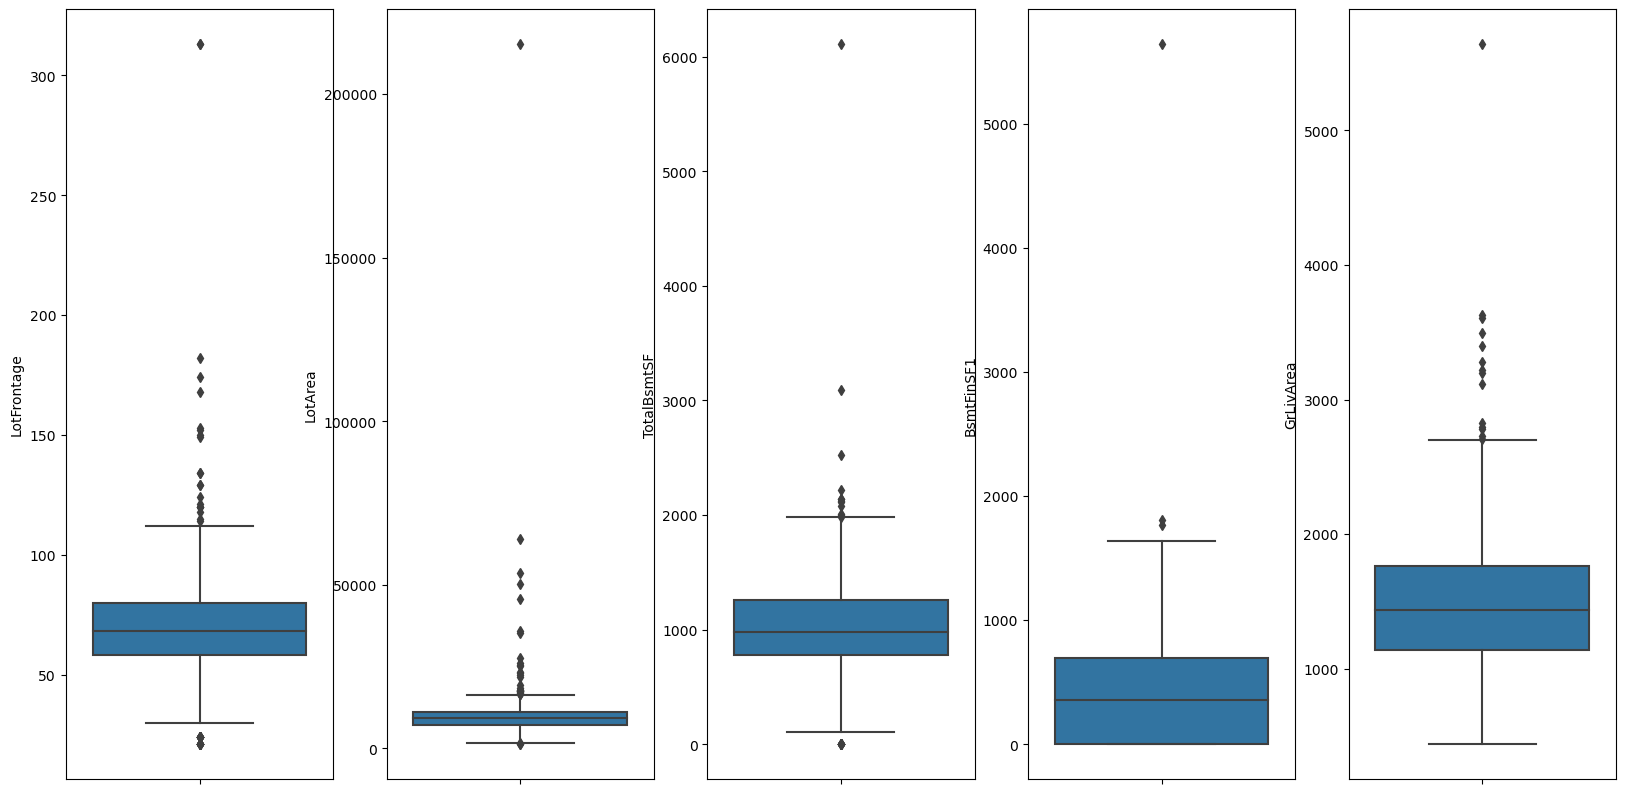

In [11]:
worst_outliers = ['LotFrontage','LotArea','TotalBsmtSF','BsmtFinSF1', 'GrLivArea']
worstOutliersFig = plt.figure(figsize = (20,10))
ax = []
for i,val in enumerate(worst_outliers):
    ax.append(worstOutliersFig.add_subplot(1,5,i+1))
    ax.append(sns.boxplot(y=val, data = train_dataset[worst_outliers].dropna()))
plt.show()
worstOutliersFig.tight_layout()

Based on the values above, we drop the values where the outliers reside

In [12]:
train_data_temp = pd.concat([train_dataset, train_labels],axis = 1) # use a temp value that contains all train data


# print the indexes in the range that we want to drop
print(train_data_temp[train_data_temp['LotFrontage'] > 250].index)
print(train_data_temp[train_data_temp['LotArea'] > 200000].index)
print(train_data_temp[train_data_temp['TotalBsmtSF'] > 5000].index)
print(train_data_temp[(train_data_temp['GrLivArea'] > 4000) & (train_data_temp['SalePrice'] < 300000)].index)
print(train_data_temp[(train_data_temp['OverallQual'] < 5) & (train_data_temp['SalePrice'] > 200000)].index)
print(train_data_temp[(train_data_temp['OverallCond'] < 5) & (train_data_temp['SalePrice'] > 300000)].index)

Int64Index([1299, 935], dtype='int64', name='Id')
Int64Index([314], dtype='int64', name='Id')
Int64Index([1299], dtype='int64', name='Id')
Int64Index([1299], dtype='int64', name='Id')
Int64Index([458], dtype='int64', name='Id')
Int64Index([379], dtype='int64', name='Id')


In [13]:
# based on previous response, procceed to remove outliers
train_dataset = train_dataset.drop([935,1299,314,458,379])
train_labels = train_labels.drop([935,1299,314,458,379])

print('outliers removed')

outliers removed


### Filling NA values

Plot NA values again, after features removal

              Features
PoolQC        0.989041
MiscFeature   0.950685
Alley         0.927397
Fence         0.794521
FireplaceQu   0.483562
LotFrontage   0.190411
GarageFinish  0.052055
GarageType    0.052055
GarageYrBlt   0.052055
GarageQual    0.052055
GarageCond    0.052055
BsmtFinType2  0.020548
BsmtExposure  0.020548
BsmtFinType1  0.020548
BsmtQual      0.020548
BsmtCond      0.020548
MasVnrType    0.002740
MasVnrArea    0.002740
Electrical    0.001370


<Axes: ylabel='Features'>

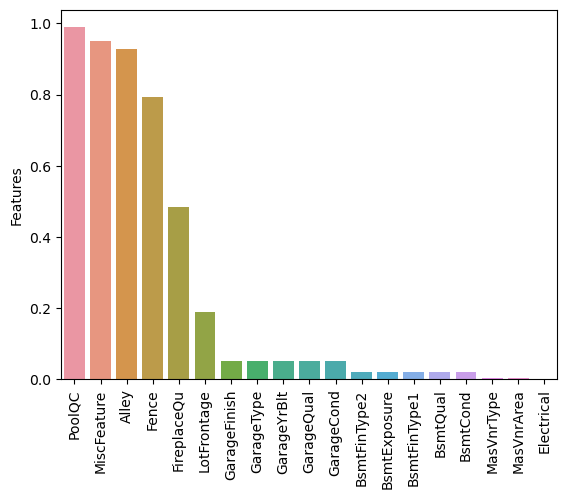

In [14]:
NA_df = pd.DataFrame({'Features':train_dataset.isnull().sum(axis = 0)/len(train_data_temp)}).sort_values(by = 'Features',ascending = False)
NA_df = NA_df.loc[NA_df['Features']!=0]
print(NA_df)
plt.xticks(rotation='vertical')
sns.barplot(x=NA_df.index,y = NA_df.Features)

**PoolQC,MiscFeature,Alley,Fence,FirePlaceQu: All NA here means there isn't one of them**

In [15]:
train_dataset[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']] = train_dataset[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].fillna('None')
val_dataset[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']] = val_dataset[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu']].fillna('None')
print('data updated')

data updated


**LotFrontage: Replace with median for neighbourhood**

In [16]:
train_dataset["LotFrontage"] = train_dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
val_dataset["LotFrontage"] = val_dataset.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))
print('data updated')

data updated


**GarageFinish,GarageQual,GarageCond,GarageType: All Na here means No Garage**

In [17]:
train_dataset[['GarageFinish','GarageQual','GarageCond','GarageType']] =train_dataset[['GarageFinish','GarageQual','GarageCond','GarageType']].fillna('None')
val_dataset[['GarageFinish','GarageQual','GarageCond','GarageType']] =val_dataset[['GarageFinish','GarageQual','GarageCond','GarageType']].fillna('None')
print('data updated')

data updated


**BsmtCond,BsmtExposure,BsmtQual,BsmtFinType2,BsmtFinType1: All Na here means no Basement**

In [18]:
train_dataset[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']] = train_dataset[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']].fillna('None')
val_dataset[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']] = val_dataset[['BsmtCond','BsmtExposure','BsmtQual','BsmtFinType2','BsmtFinType1']].fillna('None')
print('data updated')

data updated


**MasVnrType and MasVnrArea: Na means None and 0 area here**

In [19]:
train_dataset['MasVnrType'] = train_dataset['MasVnrType'].fillna('None')
train_dataset['MasVnrArea'] = train_dataset['MasVnrArea'].fillna(0)

val_dataset['MasVnrType'] = val_dataset['MasVnrType'].fillna('None')
val_dataset['MasVnrArea'] = val_dataset['MasVnrArea'].fillna(0)

print('data updated')

data updated


**MSZoning: Use MSSubclass grouping and mode to fillna**

In [20]:
train_dataset['MSZoning'] = train_dataset.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
val_dataset['MSZoning'] = val_dataset.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
print('data updated')

data updated


**Functional: NA means Typ**

In [21]:
train_dataset['Functional'] = train_dataset['Functional'].fillna('Typ')
val_dataset['Functional'] = val_dataset['Functional'].fillna('Typ')
print('data updated')

data updated


**BsmtFullBath,BsmtHalfBath,BsmtFinSF1,BsmtFinSF2: NA likely means 0 here**

In [22]:
train_dataset[['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2']] = train_dataset[['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2']].fillna(0)
val_dataset[['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2']] = val_dataset[['BsmtFullBath','BsmtHalfBath','BsmtFinSF1','BsmtFinSF2']].fillna(0)
print('data updated')

data updated


**KitchenQual,Electrical,SaleType, Exterior1st and Exterior2nd: Only 1 missing value in each here, fill with mode for neighbourhood**

In [23]:
train_dataset['KitchenQual'] = train_dataset.groupby("Neighborhood")["KitchenQual"].transform(lambda x: x.fillna(x.mode()[0]))
train_dataset['Electrical'] = train_dataset.groupby("Neighborhood")["Electrical"].transform(lambda x: x.fillna(x.mode()[0]))
train_dataset['SaleType'] = train_dataset.groupby("Neighborhood")["SaleType"].transform(lambda x: x.fillna(x.mode()[0]))
train_dataset['Exterior1st'] = train_dataset.groupby("Neighborhood")["Exterior1st"].transform(lambda x: x.fillna(x.mode()[0]))
train_dataset['Exterior2nd'] = train_dataset.groupby("Neighborhood")["Exterior2nd"].transform(lambda x: x.fillna(x.mode()[0]))

val_dataset['KitchenQual'] = val_dataset.groupby("Neighborhood")["KitchenQual"].transform(lambda x: x.fillna(x.mode()[0]))
val_dataset['Electrical'] = val_dataset.groupby("Neighborhood")["Electrical"].transform(lambda x: x.fillna(x.mode()[0]))
val_dataset['SaleType'] = val_dataset.groupby("Neighborhood")["SaleType"].transform(lambda x: x.fillna(x.mode()[0]))
val_dataset['Exterior1st'] = val_dataset.groupby("Neighborhood")["Exterior1st"].transform(lambda x: x.fillna(x.mode()[0]))
val_dataset['Exterior2nd'] = val_dataset.groupby("Neighborhood")["Exterior2nd"].transform(lambda x: x.fillna(x.mode()[0]))

print('data updated')

data updated


**GarageYrBlt and GarageCars should be replace with 0**

In [24]:
train_dataset['GarageYrBlt'] = train_dataset['GarageYrBlt'].fillna(0)
train_dataset['GarageCars'] = train_dataset['GarageCars'].fillna(0)

val_dataset['GarageYrBlt'] = val_dataset['GarageYrBlt'].fillna(0)
val_dataset['GarageCars'] = val_dataset['GarageCars'].fillna(0)

print('data updated')

data updated


**TotalBsmtSF,BsmtUnfSF and GarageArea remain. Look at rows with na value:**

In [25]:
val_dataset[['TotalBsmtSF','BsmtUnfSF']] = val_dataset[['TotalBsmtSF','BsmtUnfSF']].fillna(0)
val_dataset['GarageArea'] = val_dataset['GarageArea'].fillna(0)

print('data updated')

data updated


**Check that there are not NA**

In [26]:
NA_df = pd.DataFrame({'Features':train_dataset.isnull().sum(axis = 0)/len(train_dataset)}).sort_values(by = 'Features',ascending = False)
NA_df = NA_df.loc[NA_df['Features']!=0]
print(NA_df)

Empty DataFrame
Columns: [Features]
Index: []


### Handle Categorical Data

In [35]:
# we have categorical data, that means we need to encode it

# Because we are in a competition, we want to have consistency against the
# length of the labels, so we are going to use TargetEncoding that doesn't 
# increase the datasets

# get categorical columns
categorical_columns = [cname for cname in train_data.columns if
                    train_data[cname].nunique() < 200 and # this threshold is for all features
                    train_data[cname].dtype == "object"]

# remove categorical columns that don't exist in the dataset
removed_columns = ['Street', 'Utilities', 'Condition2', 'RoofMatl', 'Heating'] 

for column in removed_columns:
    categorical_columns.remove(column)

# print categorical columns
print(categorical_columns)
print('length of cat columns: ' + str(len(categorical_columns)))

# Initialize the encoder
# encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
encoder = TargetEncoder()

# use the encoder to fit and transform on training data
train_data_encoded = encoder.fit_transform(train_dataset[categorical_columns], train_labels)
val_data_encoded = encoder.transform(val_dataset[categorical_columns])
test_data_encoded = encoder.transform(test_data[categorical_columns])

# Convert encoded data to DataFrames and concatenate with non-categorical features
train_data_encoded_df = pd.DataFrame(train_data_encoded, columns=encoder.get_feature_names_out(categorical_columns))
val_data_encoded_df = pd.DataFrame(val_data_encoded, columns=encoder.get_feature_names_out(categorical_columns))
test_data_encoded_df = pd.DataFrame(test_data_encoded, columns=encoder.get_feature_names_out(categorical_columns))

# concatenate with the rest of the features
train_dataset_encoded = pd.concat([train_dataset.drop(categorical_columns, axis=1), train_data_encoded_df], axis=1).fillna(0)
val_dataset_encoded = pd.concat([val_dataset.drop(categorical_columns, axis=1), val_data_encoded_df], axis=1).fillna(0)
test_dataset_encoded = pd.concat([test_data.drop(categorical_columns, axis=1), test_data_encoded_df], axis=1).fillna(0)

print(len(train_data_encoded_df))
print(len(train_dataset_encoded))

train_dataset_encoded.head(10)

['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']
length of cat columns: 38
725
725


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1053,60,100.0,9500,6,6,1964,1978,272.0,442,0,...,199302.543478,205652.590596,183530.953917,184762.90229,182855.077844,177925.139889,184480.479850,178851.471182,170970.735341,172607.20034
72,20,69.0,7599,4,6,1982,2006,0.0,565,0,...,136338.344757,141999.800643,183530.953917,184762.90229,182855.077844,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
95,60,69.0,9337,6,5,1997,1997,0.0,648,0,...,199302.543478,205652.590596,183530.953917,184762.90229,182855.077844,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
1441,70,79.0,11526,6,7,1922,1994,0.0,0,0,...,136338.344757,226275.607532,183530.953917,184762.90229,182855.077844,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
34,20,70.0,10552,5,5,1959,1959,0.0,1018,0,...,199302.543478,205652.590596,183530.953917,184762.90229,182855.077844,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
1168,60,58.0,10852,6,5,2000,2000,0.0,786,0,...,199302.543478,226275.607532,183530.953917,184762.90229,182855.077844,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
449,50,50.0,8600,6,6,1937,1950,0.0,0,0,...,136338.344757,141999.800643,183530.953917,184762.90229,124358.687571,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034
446,20,73.0,9855,6,5,1956,1956,0.0,0,0,...,199302.543478,141999.800643,183530.953917,184762.90229,182855.077844,177925.139889,151100.235628,178851.471182,153370.467185,172607.20034
717,70,60.0,10800,7,8,1890,1998,0.0,0,0,...,136338.344757,141999.800643,183530.953917,184762.90229,163861.466376,177925.139889,184215.777586,178851.471182,170970.735341,172607.20034


### Data Normalization

In [36]:
# initialized the standard scaler
scaler = StandardScaler()

# normalize train data
train_data_scaled = scaler.fit_transform(train_dataset_encoded)
val_data_scaled = scaler.fit_transform(val_dataset_encoded)
test_data_scaled = scaler.fit_transform(test_dataset_encoded)

print(len(train_data_scaled))
print(len(val_data_scaled))
print(len(test_data_scaled))
print('data normalized')

725
730
1459
data normalized


## Build the model 

### Custom Model build and training

In [37]:
# this helps makes our output less verbose but still shows progress
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [188]:
model = keras.Sequential([
    Dense(128, activation='relu', input_shape=[len(train_data_scaled[0])]),
    Dropout(0.2),
    
    Dense(128, activation='relu'),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    Dropout(0.7),
    
    Dense(128, activation='relu'),
    Dropout(0.7),
    
    Dense(1) 
])

print('model built')

model built


In [189]:
# compile the model
model.compile(loss='mean_squared_error', optimizer= tf.keras.optimizers.Adam(learning_rate=0.010), metrics=['mean_squared_error'])
print('model compiled')

model compiled


In [190]:
epochs = 1000
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history = model.fit(train_data_scaled, train_labels, batch_size=32 ,epochs=epochs, verbose=0, validation_data=(val_data_scaled, val_labels), callbacks=[early_stop, PrintDot()])

hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
print()
print(hist)

train_rmse_final = np.sqrt(float(hist['mean_squared_error'].tail(1)))
val_rmse_final = np.sqrt(float(hist['val_mean_squared_error'].tail(1)))
print()
print('Final Root Mean Square Error on training set: {}'.format(round(train_rmse_final, 3)))
print('Final Root Mean Square Error on validation set: {}'.format(round(val_rmse_final, 3)))


....................................................................................................
.....................................................
             loss  mean_squared_error      val_loss  val_mean_squared_error  \
0    3.063599e+10        3.063599e+10  5.490462e+09            5.490462e+09   
1    6.889777e+09        6.889777e+09  2.053519e+09            2.053519e+09   
2    4.309261e+09        4.309261e+09  1.914141e+09            1.914141e+09   
3    4.151548e+09        4.151548e+09  1.908147e+09            1.908147e+09   
4    3.739567e+09        3.739567e+09  1.454151e+09            1.454151e+09   
..            ...                 ...           ...                     ...   
148  3.800031e+09        3.800031e+09  2.196800e+09            2.196800e+09   
149  3.404511e+09        3.404511e+09  2.819128e+09            2.819128e+09   
150  3.806209e+09        3.806209e+09  1.414718e+09            1.414718e+09   
151  3.573615e+09        3.573615e+09  1.713315e+09   

### Plot custom model training results

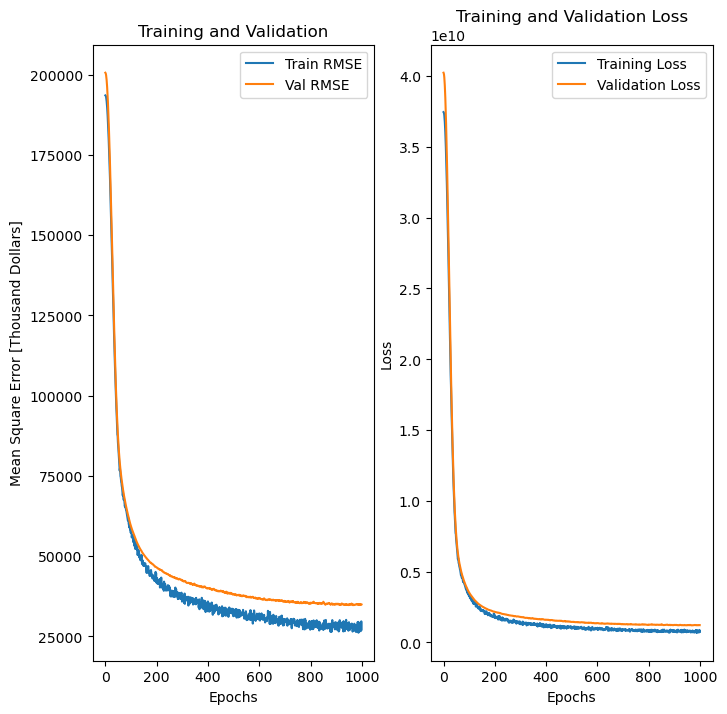

In [59]:
train_rmse = np.sqrt(np.array(history.history['mean_squared_error']))
val_rmse = np.sqrt(np.array(history.history['val_mean_squared_error']))

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error [Thousand Dollars]')
plt.plot(epochs_range, train_rmse, label='Train RMSE')
plt.plot(epochs_range, val_rmse, label='Val RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Evaluate the custom model against the validation and test data

In [191]:
preds_train = model.predict(val_data_scaled, batch_size=32)
print('MAE:', mean_absolute_error(val_labels, preds_train))

23/23 [==============================] - 0s 2ms/step
MAE: 23339.51231806507


In [168]:
preds = model.predict(test_data_scaled, batch_size=32)
print('test data predicted')

46/46 [==============================] - 0s 2ms/step
test data predicted


In [169]:
# output submission
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': preds.flatten()})
output.to_csv('submission_custom_23.csv', index=False)

print('output exported')

output exported


### Referenced model build and training

In [ ]:
def build_model():
    model = keras.Sequential([
        Dense(20, activation=tf.nn.relu, input_shape=[len(train_data_scaled[0])]),
        Dense(1)
    ])

    model.compile(optimizer="adam", 
                  loss='mse',
                  metrics=['mae', 'mse'])
    return model

In [ ]:
modelReferenced = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)
history_ref_model = modelReferenced.fit(train_data_scaled, train_labels, epochs=1000, verbose=0, validation_split = 0.1,
                    callbacks=[early_stop, PrintDot()])

hist_ref_model = pd.DataFrame(history_ref_model.history)
hist_ref_model['epoch'] = history_ref_model.epoch
print(hist)

# show RMSE measure to compare to Kaggle leaderboard on https://www.kaggle.com/c/boston-housing/leaderboard
ref_model_train_rmse_final = np.sqrt(float(hist_ref_model['mse'].tail(1)))
ref_model_val_rmse_final = np.sqrt(float(hist_ref_model['val_mse'].tail(1)))
print()
print('Final Root Mean Square Error on training set: {}'.format(round(ref_model_train_rmse_final, 3)))
print('Final Root Mean Square Error on validation set: {}'.format(round(ref_model_val_rmse_final, 3)))

### Plot referenced model results

In [ ]:
train_rmse = np.sqrt(np.array(history_ref_model.history['mse']))
val_rmse = np.sqrt(np.array(history_ref_model.history['val_mse']))

loss = history_ref_model.history['loss']
val_loss = history_ref_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error [Thousand Dollars]')
plt.plot(epochs_range, train_rmse, label='Train RMSE')
plt.plot(epochs_range, val_rmse, label='Val RMSE')
plt.legend(loc='upper right')
plt.title('Training and Validation')

plt.subplot(1, 2, 2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Referenced model evaluation and submission

In [ ]:
preds_train_ref = modelReferenced.predict(val_data_scaled, batch_size=32)
print('MAE:', mean_absolute_error(val_labels, preds_train))

In [ ]:
preds_test_ref = modelReferenced.predict(test_data_scaled, batch_size=32)
print('test data predicted')

In [ ]:
# output submission
output = pd.DataFrame({'Id': test_data.index, 'SalePrice': preds_test_ref.flatten()})
output.to_csv('submission_ref.csv', index=False)

print('output exported')